# Climpyrical Demo

This notebook shows some basic ways to manipulate CanRCM4 models using `climpyrical` levraging `xarray` and `numpy`.

In [1]:
# performs data IO
from climpyrical.data import read_data
# masking functions
from climpyrical.mask import *
# various grid operations on CanRCM4 model
from climpyrical.gridding import *

from pkg_resources import resource_filename

## Data I/O Operations

In [9]:
# path to CanRCM4 Model
PATH = resource_filename('climpyrical', 'data/model_inputs/snw_CanRCM4-LE_ens35_1951-2016_max_rl50_load_ensmean.nc')

# name of design value as found in the NetCDF4 file
dv = 'snw'

In [10]:
read_data?

Signature:
read_data(
    data_path: str,
    required_keys: list = ['rlat', 'rlon', 'lat', 'lon'],
) -> xarray.core.dataset.Dataset
Docstring:
Load NetCDF4 file. Default checks are for CanRCM4 model keys.

Note that 'rlat', 'lat', 'lon', 'rlon' are all required in addition
to a single data variable that contains a field of interest.
-----------------------------------------------------------------
Args:
    data_path (Str): path to folder
        containing CanRCM4 ensemble
    required_keys (list, optional): list of required keys in netCDF4
        file. Default requirements are only that it contains
        rotated lat and rotated lon coords called rlon and rlat
Returns:
    ds (xarray Dataset): dataset of netCDF4 file
Raises:
    FileNotFoundError: if file not found
    ValueError: if file contains unexpected or invalid data
    KeyError if NetCDF4 file is missing required keys
    TypeError if path provided is invalid
File:      ~/Desktop/pipeline/climpyrical/climpyrical/data.py
T

In [12]:
# read the data
model = read_data(PATH)
model

<xarray.Dataset>
Dimensions:  (rlat: 130, rlon: 155)
Coordinates:
  * rlat     (rlat) float64 -28.6 -28.16 -27.72 -27.28 ... 27.28 27.72 28.16
  * rlon     (rlon) float64 -33.88 -33.44 -33.0 -32.56 ... 33.0 33.44 33.88
    lat      (rlat, rlon) float64 12.36 12.52 12.68 12.84 ... 59.77 59.46 59.15
    lon      (rlat, rlon) float64 232.9 233.3 233.7 234.0 ... 335.5 335.9 336.4
Data variables:
    snw      (rlat, rlon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Aug 20 11:43:47 2019: cdo timmean snw_CanRCM4-LE_ens35_...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    Climpyrical:  CanRCM4 Reconstruction containshybrid station and model dat...

In [13]:
# Access dataset attributes using xarray
model.rlon.size, model.rlat.size

(155, 130)

In [14]:
# view dataset attributes
model.keys()

KeysView(<xarray.Dataset>
Dimensions:  (rlat: 130, rlon: 155)
Coordinates:
  * rlat     (rlat) float64 -28.6 -28.16 -27.72 -27.28 ... 27.28 27.72 28.16
  * rlon     (rlon) float64 -33.88 -33.44 -33.0 -32.56 ... 33.0 33.44 33.88
    lat      (rlat, rlon) float64 12.36 12.52 12.68 12.84 ... 59.77 59.46 59.15
    lon      (rlat, rlon) float64 232.9 233.3 233.7 234.0 ... 335.5 335.9 336.4
Data variables:
    snw      (rlat, rlon) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Tue Aug 20 11:43:47 2019: cdo timmean snw_CanRCM4-LE_ens35_...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...
    Climpyrical:  CanRCM4 Reconstruction containshybrid station and model dat...)

# Resizing the CanRCM4 Model

In [15]:
# re-grid the dataset into any new resolution (non-interpolated)
N = 3
model_regridded = regrid_ensemble(model, dv, N, copy=True)
model_regridded.rlon.size, model_regridded.rlat.size

(465, 390)

In [16]:
N = 5
model_regridded = regrid_ensemble(model, dv, N, copy=True)
model_regridded.rlon.size, model_regridded.rlat.size

(775, 650)

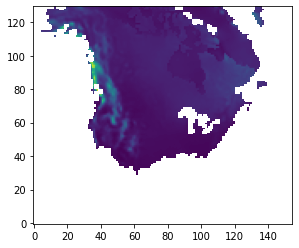

In [17]:
# display a CanRCM initialization if 3D
import matplotlib.pyplot as plt
# choose first initialization
plt.imshow(model[dv], origin='lower')

# Performing Basic Statistics

/home/nannau/Desktop/pipeline/pipevenv/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1115: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


Text(0.5, 0, 'West to East or South to North')

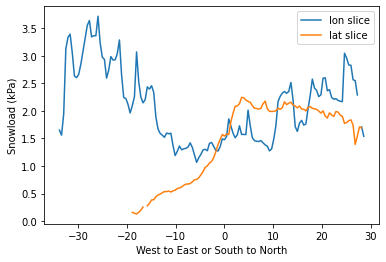

In [28]:
# perform ensemble statistics
import numpy as np
model_median_rlat = np.nanmedian(model[dv].values, axis=1)
model_median_rlon = np.nanmedian(model[dv].values, axis=0)

# plot slices
plt.plot(model.rlon, model_median_rlon, label="lon slice")
plt.plot(model.rlat, model_median_rlat, label="lat slice")
plt.legend()
plt.ylabel("Snowload (kPa)")
plt.xlabel("West to East or South to North")

# Masking

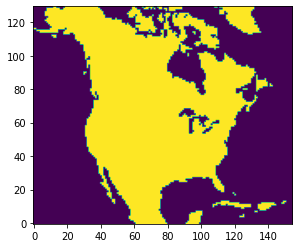

In [29]:
# load mask from file
dvmask = 'sftlf'

MASK_PATH = resource_filename('climpyrical', 'data/masks/land_mask_CanRCM4_sftlf.nc')
mask = read_data(MASK_PATH)

# convert to boolean mask
mask = mask[dvmask] > 0.

# display mask
plt.imshow(mask, origin='lower')

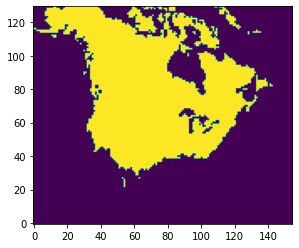

In [32]:
# combine with NaN values found in CanRCM4 model
final_mask = np.logical_and(mask, ~np.isnan(model[dv].values))
plt.imshow(final_mask, origin='lower')

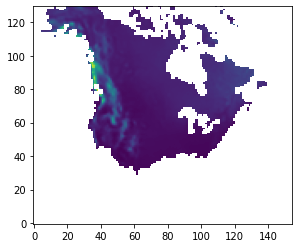

In [34]:
# apply mask and create a masked model
model[dv].values[~final_mask] = np.nan
plt.imshow(model[dv].values, origin='lower')
plt.show()

# Coordinate manipulations

In [35]:
# create paired arrays of coordinate points for every grid cell in model
x, y = flatten_coords(model.rlon.values, model.rlat.values)
x.size, y.size

(20150, 20150)

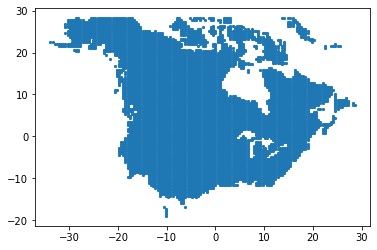

In [41]:
# get coordinate pairs for only the land values
rlon, rlat = np.meshgrid(model.rlon, model.rlat)
plt.scatter(rlon[final_mask], rlat[final_mask], marker='x', s=5)
plt.show()

In [42]:
# coordinate matching
import pandas as pd
# load station data using pandas


DF_PATH = resource_filename('climpyrical', 'data/station_inputs/sl50_rl50_for_maps.csv')

df = pd.read_csv(DF_PATH, index_col=None)
# specify name of design value in csv file
station_dv = 'SL50 (kPa)'

# transform regular coordinates into rotated pole
rlon_st, rlat_st = transform_coords(df['lon'].values, df['lat'].values)

transform_coords?

Signature:
transform_coords(
    x,
    y,
    source_crs={'init': 'epsg:4326'},
    target_crs={'proj': 'ob_tran', 'o_proj': 'longlat', 'lon_0': -97, 'o_lat_p': 42.5, 'a': 6378137, 'to_meter': 0.0174532925199, 'no_defs': True},
)
Docstring:
Rotates regular WGS84 coordinates to rotated pole
coordinates given a proj4 string that defines
the rotated poles. Projection string parameters are defined
here: https://proj.org/operations/projections/ob_tran.html
Args:
    x,y (numpy.ndarray): array containing
        latitudes and longitudes of
        stations
    source_crs (dict): proj4 dict defining source coordinates
        coordinates used.
Returns:
    x,y (tuple): tuple containing the newly rotated
        coordinates rlon, rlat
Raises:
    TypeError, ValueError in check_transform_coords_inputs
    TypeError:
            If input coords are not numpy arrays
            If crs provided are not dict
    ValueError:
            If x and y are not the same shape
            If x and y range

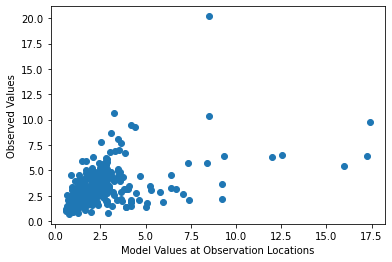

In [48]:
# find nearest grid cell locations in model to station coordinates
ix, iy = find_element_wise_nearest_pos(model.rlon.values, model.rlat.values, rlon_st, rlat_st)

plt.scatter(model[dv].values[iy, ix], df[station_dv])
plt.xlabel('Model Values at Observation Locations')
plt.ylabel('Observed Values')
plt.show()